# Определение стоимости автомобилей

**Цель проекта**

Подготовить прототип модели машинного обучения для сервиса по продаже автомобилей с пробегом «Не бит, не крашен», разрабатывающей приложение для привлечения новых клиентов, в котором можно быстро узнать рыночную стоимость своего автомобиля. Модель должна предсказать стоимость автомобиля по введенным пользователем параметрам с учетом имеющихся исторических данных по техническим характеристикам, комплектации и цене других автомобилей. 

При определении оптимальной модели должны быть учтены важные для заказчика параметры:

- качество предсказания (RMSE < 2500);
- скорость предсказания - минимальная;
- время обучения - минимальное.

**Данные для анализа**

На анализ переданы исторические данные: технические характеристики, комплектации и цены автомобилей.

**Шаги (план) проекта**

1.  Подготовка данных
2.  Обучение моделей
3.  Анализ моделей
4.  Итоговый вывод

## Подготовка данных

Импортируем необходимые библиотеки для работы с данными в текущем проекте.

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd

# построение диаграмм
import matplotlib.pyplot as plt

# машинное обучение
import lightgbm as ltb
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# оценка качества модели
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

# оценка производительности модели
import time

### Загрузка и изучение данных

Откроем датасет с данными и изучим его.

In [2]:
# открытие файла с применением конструкции try/except для исключения проблем с отработкой кода при подготовке проекта локально
try:
    df = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    df = pd.read_csv('C:/Users/User/Desktop/Обучение/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Изучим общую информацию о данных.

In [3]:
# получение общей информации о структуре датафрейма
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

1. В датасете содержится 354369 строк, 16 столбцов.
2. Требуется переименование колонок в соответствии с правилами нотации Python (латиница, нижний регистр, змеиный стиль).
3. В колонках с типом данных int64 требуется изменение типа на int32 для экономии памяти, в колонках DateCrawled, DateCreated и LastSeen требуется изменение типа данных с object на datetime.
4. Колонки VehicleType, Gearbox, Model, FuelType, NotRepaired содержат пропущенные значения, требуется обработка пропусков.
5. Требуется проверка данных на наличие явных дубликатов.
6. Требуется проверка данных на корреляцию признаков и целевого признака "Цена" для удаления из набора признаков нерелевантных.
7. Требуется проверка данных на адекватность и выбросы и обработка выбросов при их наличии.

### Переименование колонок

Переименуем столбцы в соответствии с правилами нотации Python (латиница, нижний регистр, змеиный стиль).

In [4]:
# переименование столбцов
df = df.rename(columns = {
    'DateCrawled':'date_crawled',
    'Price':'price',
    'VehicleType':'vehicle_type',
    'RegistrationYear':'registration_year',
    'Gearbox':'gearbox',
    'Power':'power',
    'Model':'model',
    'Kilometer':'kilometer',
    'RegistrationMonth':'registration_month',
    'FuelType':'fuel_type',
    'Brand':'brand',
    'NotRepaired':'not_repaired',
    'DateCreated':'date_created',
    'NumberOfPictures':'number_of_pictures',
    'PostalCode':'postal_code',
    'LastSeen':'last_seen'
}) 

Проверим результат.

In [5]:
# проверка результата
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Переименование произведено корректно.

### Типы данных

Изменим тип данных в колонках с типом данных int64 на int32 для экономии памяти.

In [6]:
# изменение типов данных
df[df.select_dtypes(np.int64).columns] = df.select_dtypes(np.int64).astype(np.int32)

Изменим тип данных в колонках date_crawled, date_created и last_seen с object на datetime.

In [7]:
# изменение типа данных в колонках date_crawled, date_created и last_seen на datetime
df['date_crawled'] = pd.to_datetime(df['date_crawled']) 
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

Проверим результат.

In [8]:
# получение общей информации о структуре датафрейма
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int32         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int32         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int32         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int32         
 8   registration_month  354369 non-null  int32         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  not_repaired        283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

Изменение типов данных произведено корректно.

### Дубликаты

Проверим датафрейм на наличие явных дубликатов.

In [9]:
# проверка наличия явных дубликатов
df.duplicated().sum()

4

Дубликатов мало, поэтому удалим их.

In [10]:
# удаление дубликатов с переиндексацией
df = df.drop_duplicates().reset_index(drop=True)

Проверим результат.

In [11]:
# проверка наличия явных дубликатов
df.duplicated().sum()

0

Дубликаты удалены корректно.

### Пропуски

Определим, в каких колонках есть пропущенные значения, и сколько их в % отношении.

In [12]:
# проверка % пропущенных значений в колонках
(df.isna().mean()*100).round(2)

date_crawled           0.00
price                  0.00
vehicle_type          10.58
registration_year      0.00
gearbox                5.60
power                  0.00
model                  5.56
kilometer              0.00
registration_month     0.00
fuel_type              9.28
brand                  0.00
not_repaired          20.08
date_created           0.00
number_of_pictures     0.00
postal_code            0.00
last_seen              0.00
dtype: float64

Обработаем пропущенные значения по порядку.

**vehicle_type**

In [13]:
# вывод строк с пустыми значениями в колонке
df[df['vehicle_type'].isnull()].head(10) 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
16,2016-04-01 12:46:46,300,NaN,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
22,2016-03-23 14:52:51,2900,NaN,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33
26,2016-03-10 19:38:18,5555,NaN,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
31,2016-03-29 16:57:02,899,NaN,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,NaN,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50
37,2016-03-28 17:50:15,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,NaN,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
48,2016-03-25 14:40:12,7750,NaN,2017,manual,80,golf,100000,1,petrol,volkswagen,NaN,2016-03-25,0,48499,2016-03-31 21:47:44
51,2016-03-07 18:57:08,2000,NaN,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08


Поскольку однозначно определить по данным таблицы тип автомобиля в строках с пропущенными значениями нельзя, при этом вес таких значений в выборке высок (более 6%), заменим пропуски пометкой no info.

In [14]:
# заполнение пропусков пометкой no info
df['vehicle_type'] = df['vehicle_type'].fillna('no info')

Проверим результат.

In [15]:
# вывод строк с пустыми значениями в колонке
df[df['vehicle_type'].isnull()] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Пропущенных значений не осталось, заполнение произведено корректно.

**gearbox**

In [16]:
# вывод строк с пустыми значениями в колонке
df[df['gearbox'].isnull()].head(10) 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
16,2016-04-01 12:46:46,300,no info,2016,NaN,60,polo,150000,0,petrol,volkswagen,NaN,2016-04-01,0,38871,2016-04-01 12:46:46
32,2016-03-15 20:59:01,245,sedan,1994,NaN,0,golf,150000,2,petrol,volkswagen,no,2016-03-15,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,no info,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,2016-03-28,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,no info,1990,NaN,0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
69,2016-04-01 11:56:40,1200,coupe,2001,NaN,0,astra,150000,0,NaN,opel,NaN,2016-04-01,0,47249,2016-04-07 08:46:07
92,2016-03-16 07:56:19,250,no info,2000,NaN,60,ka,150000,0,NaN,ford,NaN,2016-03-16,0,51427,2016-03-21 09:47:08
94,2016-03-28 16:37:43,8390,no info,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,2016-03-28,0,29221,2016-03-30 07:44:59
110,2016-04-03 03:57:26,350,small,1998,NaN,0,corsa,150000,2,petrol,opel,NaN,2016-04-03,0,82110,2016-04-03 08:53:37
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20,0,37520,2016-04-07 02:45:22


Поскольку однозначно определить по данным таблицы тип коробки предач в строках с пропущенными значениями нельзя, при этом вес таких значений в выборке небольшой (менее 6%), удалим строки с пропусками.

In [17]:
# удаление строк с пропущенными значениями
df = df.dropna(subset=['gearbox']).reset_index(drop=True)

Проверим результат.

In [18]:
# вывод строк с пустыми значениями в колонке
df[df['gearbox'].isnull()] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Пропущенных значений не осталось, удаление произведено корректно.

**model**

In [19]:
# вывод строк с пустыми значениями в колонке
df[df['model'].isnull()].head(10) 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
54,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
75,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03,0,45665,2016-04-05 11:47:13
124,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27,0,38709,2016-04-05 20:17:31
146,2016-03-19 19:49:15,500,small,1999,manual,0,NaN,150000,0,petrol,renault,no,2016-03-19,0,26969,2016-04-01 11:17:48
177,2016-03-27 12:47:45,1200,coupe,1990,manual,45,NaN,150000,0,petrol,volkswagen,NaN,2016-03-27,0,83317,2016-04-07 08:17:08
240,2016-04-04 09:49:59,450,no info,2016,manual,0,NaN,150000,3,petrol,mitsubishi,no,2016-04-04,0,59302,2016-04-06 11:17:11
253,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29,0,32791,2016-04-06 20:16:34
282,2016-03-13 13:38:54,1600,wagon,1999,manual,0,NaN,150000,6,petrol,bmw,no,2016-03-13,0,41199,2016-03-28 12:46:35
325,2016-03-08 08:57:34,5500,small,2012,manual,68,NaN,40000,12,NaN,peugeot,no,2016-03-08,0,24536,2016-03-21 21:44:28


Поскольку однозначно определить по данным таблицы модель авто в строках с пропущенными значениями нельзя, при этом вес таких значений в выборке небольшой (менее 6%), удалим строки с пропусками.

In [20]:
# удаление строк с пропущенными значениями
df = df.dropna(subset=['model']).reset_index(drop=True)

Проверим результат.

In [21]:
# вывод строк с пустыми значениями в колонке
df[df['model'].isnull()] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Пропущенных значений не осталось, удаление произведено корректно.

**fuel_type**

In [22]:
# вывод строк с пустыми значениями в колонке
df[df['fuel_type'].isnull()].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
8,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
12,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21,0,90762,2016-03-23 02:50:54
23,2016-03-10 19:38:18,5555,no info,2017,manual,125,c4,125000,4,NaN,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46
32,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
35,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,NaN,mercedes_benz,NaN,2016-03-30,0,33649,2016-04-03 11:44:49
46,2016-04-04 10:57:36,1400,no info,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04,0,34454,2016-04-06 12:45:43
48,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,2016-03-17,0,88433,2016-04-04 04:17:32
51,2016-03-10 20:53:19,2399,no info,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37
58,2016-03-28 17:41:27,10900,no info,2017,manual,101,astra,50000,3,NaN,opel,no,2016-03-28,0,63607,2016-04-06 23:15:52
63,2016-03-07 08:55:18,2300,no info,1997,manual,150,5er,150000,3,NaN,bmw,no,2016-03-07,0,79341,2016-03-22 05:15:22


Поскольку однозначно определить по данным таблицы тип двигателя в строках с пропущенными значениями нельзя, при этом вес таких значений в выборке высок (более 6%), заменим пропуски пометкой no info.

In [23]:
# заполнение пропусков пометкой no info
df['fuel_type'] = df['fuel_type'].fillna('no info')

Проверим результат.

In [24]:
# вывод строк с пустыми значениями в колонке
df[df['fuel_type'].isnull()] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Пропущенных значений не осталось, заполнение произведено корректно.

**not_repaired**

In [25]:
# вывод строк с пустыми значениями в колонке
df[df['not_repaired'].isnull()].head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,no info,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
7,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04,0,94505,2016-04-04 23:42:13
8,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,no info,volkswagen,NaN,2016-03-17,0,27472,2016-03-31 17:17:06
11,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15,0,37269,2016-04-01 13:16:16
28,2016-03-29 16:57:02,899,no info,2016,manual,60,clio,150000,6,petrol,renault,NaN,2016-03-29,0,37075,2016-03-29 17:43:07
32,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,no info,opel,NaN,2016-03-11,0,2943,2016-04-07 03:46:09
35,2016-03-30 20:38:20,7500,sedan,2002,auto,306,e_klasse,150000,4,no info,mercedes_benz,NaN,2016-03-30,0,33649,2016-04-03 11:44:49
36,2016-03-24 00:52:09,12500,sedan,2006,auto,231,5er,150000,11,gasoline,bmw,NaN,2016-03-23,0,46119,2016-04-04 16:18:19
38,2016-03-17 12:44:43,3900,small,2008,auto,61,fortwo,80000,6,petrol,smart,NaN,2016-03-17,0,21073,2016-03-19 11:46:17


Поскольку однозначно определить по данным таблицы, ремонтировался ли автомобиль, в строках с пропущенными значениями нельзя, при этом вес таких значений в выборке высок (более 6%), заменим пропуски пометкой no info.

In [26]:
# заполнение пропусков пометкой no info
df['not_repaired'] = df['not_repaired'].fillna('no info')

Проверим результат.

In [27]:
# вывод строк с пустыми значениями в колонке
df[df['fuel_type'].isnull()] 

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Пропущенных значений не осталось, заполнение произведено корректно.

Оценим состояние выборки после обработки пропусков.

In [28]:
# вывоб общей информации о выборке
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318958 entries, 0 to 318957
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        318958 non-null  datetime64[ns]
 1   price               318958 non-null  int32         
 2   vehicle_type        318958 non-null  object        
 3   registration_year   318958 non-null  int32         
 4   gearbox             318958 non-null  object        
 5   power               318958 non-null  int32         
 6   model               318958 non-null  object        
 7   kilometer           318958 non-null  int32         
 8   registration_month  318958 non-null  int32         
 9   fuel_type           318958 non-null  object        
 10  brand               318958 non-null  object        
 11  not_repaired        318958 non-null  object        
 12  date_created        318958 non-null  datetime64[ns]
 13  number_of_pictures  318958 no

Выборка сократилась на ~10%, пропусков нет.

### Очистка выборки от нерелевантных признаков

Чтобы оставить в наборе признаков только релевантые числовые признаки для целевого признака "Цена", оценим корреляцию числовых признаков и целевого признака в выборке.

In [29]:
# снятие ограничения на количество отображаемых строк
pd.set_option('display.max_rows', None)
# расчет корреляции между признаками
df.corr().round(2)

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.00,0.10,0.15,-0.38,0.08,NaN,0.07
registration_year,0.10,1.00,0.01,-0.08,0.00,NaN,0.00
power,0.15,0.01,1.00,0.02,0.03,NaN,0.02
kilometer,-0.38,-0.08,0.02,1.00,-0.01,NaN,-0.01
registration_month,0.08,0.00,0.03,-0.01,1.00,NaN,0.01
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.07,0.00,0.02,-0.01,0.01,NaN,1.00


По итогу расчета корреляции колонки number_of_picture, postal_code и registration_month	могут быть удалены как колонки со слабой корреляцией.

Логично также предположить, что колонки с датами date_crawled, date_created и last_seen не имеют взаимосвязи с ценой, поэтому их также можно удалить.

Сформируем итоговый датасет для дальнейшей работы.

In [30]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [31]:
# формирование выборки с нужными колонками
df_fin = df[
    ['price',
     'vehicle_type',
     'registration_year',
     'gearbox',
     'power',
     'model',
     'kilometer',
     'fuel_type',
     'brand',
     'not_repaired']
     ]
# проверка результата
df_fin.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,no info,1993,manual,0,golf,150000,petrol,volkswagen,no info
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no info
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [32]:
# проверка результата
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318958 entries, 0 to 318957
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              318958 non-null  int32 
 1   vehicle_type       318958 non-null  object
 2   registration_year  318958 non-null  int32 
 3   gearbox            318958 non-null  object
 4   power              318958 non-null  int32 
 5   model              318958 non-null  object
 6   kilometer          318958 non-null  int32 
 7   fuel_type          318958 non-null  object
 8   brand              318958 non-null  object
 9   not_repaired       318958 non-null  object
dtypes: int32(4), object(6)
memory usage: 19.5+ MB


Итоговая выборка содержит 10 колонок (9 признаков и 1 целевой признак), 318958 строк. 4 колонки с числовыми данными, 6 колонок с категориальными.

### Адекватность данных и выбросы

Проверим колонки итоговой выборки на адекватность данных и выбросы.

**Числовые колонки price, registration_year, power, kilometer**

In [33]:
# вывод статистики по значениям в числовых колонках выборки
df_fin.describe().round(2)

,price,registration_year,power,kilometer
count,318958.00,318958.00,318958.00,318958.00
mean,4608.91,2003.43,114.97,128844.74
std,4564.24,30.52,185.63,36620.68
min,0.00,1000.00,0.00,5000.00
25%,1200.00,1999.00,75.00,125000.00
50%,2900.00,2003.00,105.00,150000.00
75%,6700.00,2008.00,143.00,150000.00
max,20000.00,9000.00,20000.00,150000.00


Построим диаграмму размаха для оценки выбросов.

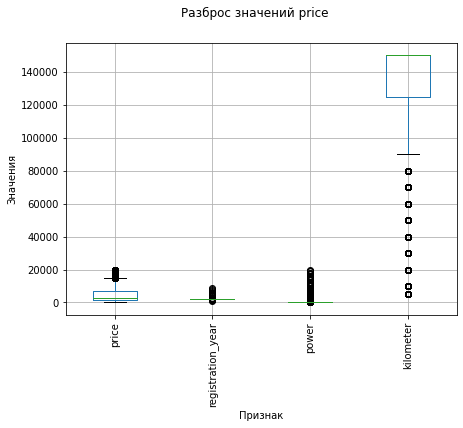

In [34]:
# построение диаграммы размаха
df_fin[['price', 'registration_year', 'power', 'kilometer']].boxplot(figsize=(7, 5))
plt.suptitle('Разброс значений price')
plt.title(None)
plt.xlabel('Признак'), plt.ylabel('Значения')
plt.xticks(rotation=90)
plt.show()

**price**

Поскольку признак price является целевым, удалим из выборки строки с экстремально низкими значениями в колонке price как строки с высокой вероятностью ошибки в данных по цене во избежание искажений при последующем обучении и предсказании.

In [35]:
# удаление из выборки строк со значениями price менее 29 евро
df_fin = df_fin.loc[df_fin['price'] > 29]

In [36]:
# вывод статистики по значениям в колонке price
df_fin.describe().round(2)

,price,registration_year,power,kilometer
count,310993.00,310993.00,310993.00,310993.00
mean,4726.94,2003.44,115.32,128766.64
std,4561.57,25.06,183.23,36524.04
min,30.00,1000.00,0.00,5000.00
25%,1299.00,1999.00,75.00,125000.00
50%,2999.00,2003.00,105.00,150000.00
75%,6850.00,2008.00,143.00,150000.00
max,20000.00,8200.00,20000.00,150000.00


После удаления экстремально низких цен минимальное значение price равно 30, максимальное 20 000, среднее 4726, медиана 2999. Не будем удалять выбросы справа, т.к. нет оснований предполагать, что цена автомобиля не может быть 20 000 евро.

**registration_year**

Выведем значения столбца для визуальной оценки наличия ошибок в данных.

In [37]:
# вывод уникальных значений столбца
df_fin['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1994, 1996, 1989, 2015, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1966, 1975, 1968,
       1963, 1961, 1967, 1960, 1500, 1964, 1910, 2019, 1937, 1951, 1953,
       1954, 1959, 1958, 1956, 2900, 5911, 1962, 1400, 1950, 4000, 1932,
       1952, 3700, 5000, 1942, 1957, 1923, 1930, 1929, 1943, 1938, 1934,
       1935, 1936, 1000, 6000, 1928, 1931, 4500, 1602, 1927, 7100, 1933,
       8200, 1947, 1600], dtype=int32)

Отсортируем Series для удобства.

In [38]:
# сортировка значений колонки registration_year
s = pd.Series(df_fin['registration_year'].unique())
s.sort_values()

90     1000
73     1400
59     1500
101    1600
95     1602
61     1910
82     1923
96     1927
92     1928
84     1929
83     1930
93     1931
76     1932
98     1933
87     1934
88     1935
89     1936
63     1937
86     1938
80     1942
85     1943
44     1945
100    1947
74     1950
64     1951
77     1952
65     1953
66     1954
46     1955
69     1956
81     1957
68     1958
67     1959
58     1960
56     1961
72     1962
55     1963
60     1964
42     1965
52     1966
57     1967
54     1968
36     1969
43     1970
37     1971
50     1972
35     1973
45     1974
53     1975
48     1976
51     1977
47     1978
49     1979
40     1980
16     1981
33     1982
34     1983
20     1984
32     1985
41     1986
38     1987
39     1988
30     1989
14     1990
19     1991
26     1992
0      1993
28     1994
4      1995
29     1996
13     1997
6      1998
22     1999
25     2000
2      2001
11     2002
17     2003
1      2004
7      2005
21     2006
9      2007
3      2008
10     2009
24  

Избавимся от выбросов в данных - удалим строки с годами до 1930 и после 2019.

In [39]:
# удаление из выбросов
df_fin = df_fin.loc[df_fin['registration_year'] > 1929]
df_fin = df_fin.loc[df_fin['registration_year'] < 2020]

Проверим результат.

In [40]:
# вывод уникальных значений столбца
df_fin['registration_year'].unique()

array([1993, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2011, 2007, 2009,
       2002, 2018, 1997, 1990, 2017, 1981, 2003, 2016, 1991, 1984, 2006,
       1999, 2012, 2010, 2000, 1992, 2013, 1994, 1996, 1989, 2015, 1985,
       1982, 1983, 1973, 1969, 1971, 1987, 1988, 1980, 1986, 1965, 1970,
       1945, 1974, 1955, 1978, 1976, 1979, 1972, 1977, 1966, 1975, 1968,
       1963, 1961, 1967, 1960, 1964, 2019, 1937, 1951, 1953, 1954, 1959,
       1958, 1956, 1962, 1950, 1932, 1952, 1942, 1957, 1930, 1943, 1938,
       1934, 1935, 1936, 1931, 1933, 1947], dtype=int32)

В выборке остались строки без выбросов.

**power**

Выведем значения столбца для визуальной оценки наличия ошибок в данных.

In [41]:
# вывод уникальных значений колонки power с сортировкой
f = pd.Series(df_fin['power'].unique())
f.sort_values()

0          0
291        1
242        2
659        3
330        4
334        5
432        6
354        7
351        8
347        9
319       10
321       11
325       12
349       13
301       14
262       15
209       16
335       17
255       18
361       19
318       20
287       21
274       22
139       23
341       24
323       25
190       26
315       27
500       28
298       29
188       30
447       31
405       32
149       33
241       34
225       35
476       36
175       37
299       38
118       39
200       40
71        41
276       42
125       43
104       44
68        45
215       46
189       47
158       48
328       49
17        50
120       51
88        52
123       53
55        54
33        55
75        56
182       57
78        58
114       59
21        60
29        61
258       62
101       63
35        64
90        65
86        66
127       67
95        68
3         69
26        70
92        71
132       72
84        73
87        74
2         75
201       76

Избавимся от выбросов в данных - удалим строки с мощностью до 20 лс и более 2000 лс.

In [42]:
# удаление из выбросов
df_fin = df_fin.loc[df_fin['power'] > 19]
df_fin = df_fin.loc[df_fin['power'] < 2001]

Проверим результат.

In [43]:
# вывод уникальных значений колонки power с сортировкой
f = pd.Series(df_fin['power'].unique())
f.sort_values()

308      20
280      21
268      22
138      23
324      24
311      25
189      26
305      27
440      28
290      29
187      30
405      31
372      32
148      33
238      34
223      35
425      36
174      37
291      38
117      39
199      40
70       41
270      42
124      43
103      44
67       45
213      46
188      47
157      48
315      49
16       50
119      51
87       52
122      53
54       54
32       55
74       56
181      57
77       58
113      59
20       60
28       61
253      62
100      63
34       64
89       65
85       66
126      67
94       68
2        69
25       70
91       71
131      72
83       73
86       74
1        75
200      76
50       77
195      78
161      79
30       80
101      81
38       82
104      83
44       84
82       85
43       86
41       87
60       88
197      89
15       90
196      91
118      92
203      93
183      94
27       95
141      96
92       97
69       98
19       99
80      100
6       101
3       102
97  

В выборке остались строки без выбросов по мощности.

**kilometer**

Значения в колонке kilometer распределены в диапазоне  5 000 - 150 000, оставим их без изменений, т.к. нет объективных оснований сомневаться в их достоверности.

Выведем статистическую информацию по числовым колонкам выборки после проведенной обработки выбросов.

In [44]:
# вывод статистики по значениям числовых колонок
df_fin.describe().round(2)

,price,registration_year,power,kilometer
count,288520.00,288520.00,288520.00,288520.00
mean,4899.95,2003.37,121.51,128475.34
std,4608.01,6.67,62.25,36466.65
min,30.00,1930.00,20.00,5000.00
25%,1399.00,1999.00,77.00,125000.00
50%,3200.00,2003.00,111.00,150000.00
75%,6999.00,2008.00,150.00,150000.00
max,20000.00,2019.00,2000.00,150000.00


In [45]:
# вывод общей информации о выборке
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288520 entries, 1 to 318957
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288520 non-null  int32 
 1   vehicle_type       288520 non-null  object
 2   registration_year  288520 non-null  int32 
 3   gearbox            288520 non-null  object
 4   power              288520 non-null  int32 
 5   model              288520 non-null  object
 6   kilometer          288520 non-null  int32 
 7   fuel_type          288520 non-null  object
 8   brand              288520 non-null  object
 9   not_repaired       288520 non-null  object
dtypes: int32(4), object(6)
memory usage: 19.8+ MB


**Категориальные колонки vehicle_type, gearbox, model, fuel_type, brand, not_repaired**

**vehicle_type**

Выведем уникальные значения столбца.

In [46]:
df_fin['vehicle_type'].unique()

array(['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'coupe',
       'no info', 'other'], dtype=object)

Поскольку по смыслу 'no info' и 'other' одинаковы (точная классификация неизвестна), объединим их, заменив тегом other/no info.

In [47]:
# замена отсутствующих значений на other/no info
df_fin.loc[df_fin['vehicle_type'] == 'no info', 'vehicle_type'] = 'other/no info'
df_fin.loc[df_fin['vehicle_type'] == 'other', 'vehicle_type'] = 'other/no info'

Проверим результат.

In [48]:
df_fin['vehicle_type'].unique()

array(['suv', 'small', 'sedan', 'convertible', 'bus', 'wagon', 'coupe',
       'other/no info'], dtype=object)

Замена произведена корректно.

**gearbox**

Выведем уникальные значения столбца.

In [49]:
df_fin['gearbox'].unique()

array(['auto', 'manual'], dtype=object)

Значения адекватны и не требуют обработки.

**model**

Выведем уникальные значения столбца.

In [50]:
df_fin['model'].value_counts()

golf                  25447
other                 20369
3er                   17551
polo                  10890
corsa                 10231
astra                  9251
passat                 8874
a4                     8868
c_klasse               7373
5er                    7126
e_klasse               5981
a3                     5471
focus                  5154
a6                     4985
fiesta                 4858
2_reihe                4386
transporter            4140
twingo                 3783
vectra                 3531
a_klasse               3468
1er                    3341
fortwo                 3243
3_reihe                3064
touran                 3043
mondeo                 3038
clio                   2902
punto                  2681
zafira                 2589
ibiza                  2416
megane                 2393
lupo                   2160
ka                     2052
octavia                1936
fabia                  1908
cooper                 1858
clk                 

Неявных дублей нет, оставим без изменений.

**fuel_type**

Выведем уникальные значения столбца.

In [51]:
df_fin['fuel_type'].unique()

array(['gasoline', 'petrol', 'no info', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Типы топлива gasoline и petrol - одно и то же, объединим их под названием petrol.

Отсутствующую информацию 'no info' и 'other' также объединим в категорию other/no info.

In [52]:
# замена отсутствующих значений на other/no info
df_fin.loc[df_fin['fuel_type'] == 'no info', 'fuel_type'] = 'other/no info'
df_fin.loc[df_fin['fuel_type'] == 'other', 'fuel_type'] = 'other/no info'

# объединение gasoline и petrol
df_fin.loc[df_fin['fuel_type'] == 'gasoline', 'fuel_type'] = 'petrol'

Проверим результат.

In [53]:
df_fin['fuel_type'].unique()

array(['petrol', 'other/no info', 'lpg', 'hybrid', 'cng', 'electric'],
      dtype=object)

Замена произведена корректно.

**brand**

Выведем уникальные значения столбца.

In [54]:
df_fin['brand'].unique()

array(['jeep', 'volkswagen', 'skoda', 'bmw', 'peugeot', 'ford', 'mazda',
       'nissan', 'renault', 'mercedes_benz', 'opel', 'seat', 'citroen',
       'honda', 'fiat', 'mini', 'smart', 'hyundai', 'audi', 'alfa_romeo',
       'subaru', 'volvo', 'mitsubishi', 'kia', 'suzuki', 'lancia',
       'toyota', 'chevrolet', 'dacia', 'daihatsu', 'chrysler', 'jaguar',
       'daewoo', 'rover', 'porsche', 'saab', 'land_rover', 'trabant',
       'lada'], dtype=object)

Неявных дублей нет, оставим без изменений.

**not_repaired**

Выведем уникальные значения столбца.

In [55]:
df_fin['not_repaired'].unique()

array(['no info', 'no', 'yes'], dtype=object)

Значения адекватны, оставим без изменений.

Оценим итоговую выборку после предобработки.

In [56]:
# переиндексация и вывод общей информации о выборке
df_fin = df_fin.reset_index(drop=True)
df_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288520 entries, 0 to 288519
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              288520 non-null  int32 
 1   vehicle_type       288520 non-null  object
 2   registration_year  288520 non-null  int32 
 3   gearbox            288520 non-null  object
 4   power              288520 non-null  int32 
 5   model              288520 non-null  object
 6   kilometer          288520 non-null  int32 
 7   fuel_type          288520 non-null  object
 8   brand              288520 non-null  object
 9   not_repaired       288520 non-null  object
dtypes: int32(4), object(6)
memory usage: 17.6+ MB


In [57]:
# вывод первых 5 строк датасета
df_fin.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no info
1,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
3,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no


Выборка для дальнейшей работы содержит 10 колонок, 288520 строк, пропусков и дублей нет.

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод** 
  
В ходе обработки выборки на данном этапе проделаны следующие работы:
    
1. Загружена и изучена выборка с данными: исходный датасет содержит 354369 строк, 16 столбцов.
2. Проведена предобработка данных: 
 * переименованы колонки в соответсвии с правилами нотации Python, 
 * заменены типы данных int64 на  int32 и int64 на datetime,
 * обработаны пропуски в колонках VehicleType, Gearbox, Model, FuelType, NotRepaired,
 * проведена проверка на дубликаты и их обработка,
 * проведена проверка на корреляцию числовых признаков и целевого признака "Цена", удалены колонки с нерелевантными признаками
 * проведена проверка данных на адекватность и обработка выбросов.

Итоговая выборка для дальшейшей работы содержит 288520 строк, 10 столбцов, пропусков и дублей нет. 
   
<div>

## Обучение моделей

### Подготовка выборки к обучению

Проведем подготовку выборки к обучению:
1. обработаем категориальные признаки техникой OHE для перевода их в цифровые значения
2. разделим выборку на обучающую и тестовую выборки
3. проведем стандартизацию количественных признаков

**Обработка категориальных признаков техникой OHE**

In [58]:
# преобразование категориальных признаков в количественные техникой OHE
df_fin_ohe = pd.get_dummies(df_fin, drop_first = True)

In [59]:
# вывод результата
df_fin_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other/no info,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no info,not_repaired_yes
0,9800,2004,163,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,1500,2001,75,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,3600,2008,69,90000,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,650,1995,102,150000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2200,2004,109,150000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# вывод общей информации о выборке после обработки
df_fin_ohe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288520 entries, 0 to 288519
Columns: 305 entries, price to not_repaired_yes
dtypes: int32(4), uint8(301)
memory usage: 87.2 MB


**Разделение выборки на features и target и на обучающую и тестовую выборки**

Установим RandomState равным 12345.

In [61]:
# фиксирование RandomState
state = np.random.RandomState(12345)

Разделим датафрейм на выборки с признаками и целевым признаком.

In [62]:
# разделение датафрейма на выборки с признаками и целевым признаком
features_train, features_test, target_train, target_test = train_test_split(
    df_fin_ohe.drop(['price'], axis=1), df_fin_ohe['price'], test_size=0.25, random_state = state 
)

Оценим размер получившихся выборок.

In [63]:
# вывод размера выборки
features_train.shape

(216390, 304)

In [64]:
# вывод размера выборки
target_train.shape

(216390,)

In [65]:
# вывод размера выборки
features_test.shape

(72130, 304)

In [66]:
# вывод размера выборки
target_test.shape

(72130,)

Разделение на выборки прошло корректно.

**Стандартизация количественных признаков**

Поскольку в данных присутствуют количественные признаки с разными разбросами значений, во избежание присвоения бОльшего веса 
признакам с бОльшими значениями и разбросом приведем количественные признаки к одному масштабу.

In [67]:
# код от предупреждения SettingWithCopy
pd.options.mode.chained_assignment = None
# формирование списка стобцов и создание структуры для стандартизации
numeric=['registration_year', 'power', 'kilometer']
scaler = StandardScaler()
# настройка стандартизации на обучающих данных
scaler.fit(features_train[numeric]) 
# стандартизация выборок для обучения, валидации и тестирования
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Выведем первые 5 строк выборок с признаками для оценки результата.

In [68]:
# вывод первых 5 строк выборки
features_train.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other/no info,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no info,not_repaired_yes
57894,-1.853751,-1.166155,-1.055872,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
134837,-0.954434,-0.317719,0.589576,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
260428,-0.205004,0.547033,0.589576,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
212600,-1.254206,-0.513512,0.589576,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
71497,0.244655,0.302292,0.589576,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [69]:
# вывод первых 5 строк выборки
features_test.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other/no info,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_no info,not_repaired_yes
47445,0.094769,0.465452,0.589576,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
246946,0.394541,-0.937730,-0.781631,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
111637,-1.703865,0.465452,0.589576,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88104,1.293857,-0.366667,-2.427079,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
11468,-1.553979,2.912863,-0.781631,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Стандартизация проведена корректно.

### Обучение моделей

Проведем обучение моделей на обучающей выборке и оценим время обучения и скорость предсказания, а также качество предсказания с помощью метрики RMSE для моделей:
1. Линейной регрессии
2. Линейной регрессии, обученной с помощью алгоритма SGD
3. Линейной регрессии, обученной с помощью алгоритма SGD, с регуляризацией
4. Случайного леса
5. LGBM

**Линейная регрессия**

Создадим модель линейной регрессии и оценим на данных обучающей выборки ее качество, время обучения и скорость предсказания.

In [70]:
# создание модели
model_lr = LinearRegression()

In [71]:
# обучение модели на обучающей выборке и оценка времени этого обучения
%time
model_lr.fit(features_train, target_train)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


LinearRegression()

In [72]:
# предсказание модели на обучающей выборке и оценка времени этого предсказания
%time
target_pred_lr = model_lr.predict(features_train)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 5.72 µs


In [73]:
# расчет RMSE 
result_lr = mean_squared_error(target_train, target_pred_lr, squared=False)
print("RMSE линейной регрессии на обучающей выборке:", result_lr)

RMSE линейной регрессии на обучающей выборке: 2666.0507816168806


**Линейная регрессия, обученная с помощью алгоритма SGD**

Создадим модель линейной регрессии, обученной с помощью алгоритма SGD, и оценим на данных обучающей выборки ее качество, время обучения и скорость предсказания.

Создадим класс модели линейной регрессии, обученной с помощью алгоритма SGD.

In [74]:
# создание класса модели
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                
                w -= gradient * self.step_size

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [76]:
# сознание модели с учетом класса выше
model_lr_sgd = SGDLinearRegression(0.01, 10, 100)

In [77]:
# обучение модели на обучающей выборке и оценка времени этого обучения
%time
model_lr_sgd.fit(features_train, target_train)

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 7.87 µs


In [78]:
# предсказание модели на обучающей выборке и оценка времени этого предсказания
%time
target_pred_lr_sgd = model_lr_sgd.predict(features_train)

CPU times: user 7 µs, sys: 18 µs, total: 25 µs
Wall time: 7.63 µs


In [79]:
# расчет RMSE 
result_lr_sgd = mean_squared_error(target_train, target_pred_lr_sgd, squared=False)
print("RMSE линейной регрессии с SGD на обучающей выборке:", result_lr_sgd)

RMSE линейной регрессии с SGD на обучающей выборке: 2732.903138618965


**Линейная регрессия, обученная с помощью алгоритма SGD, с регуляризацией**

Создадим модель линейной регрессии, обученной с помощью алгоритма SGD, применим регуляризацию и оценим на данных обучающей выборки ее качество, время обучения и скорость предсказания.

Создадим класс модели линейной регрессии, обученной с помощью алгоритма SGD, с применением регуляризации

In [80]:
# создание класса модели
class SGDLinearRegression:
    def __init__(self, step_size, epochs, batch_size, reg_weight):
        self.step_size = step_size
        self.epochs = epochs
        self.batch_size = batch_size
        self.reg_weight = reg_weight
    
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)        
        y = train_target
        w = np.zeros(X.shape[1])
        
        for _ in range(self.epochs):
            batches_count = X.shape[0] // self.batch_size
            for i in range(batches_count):
                begin = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[begin:end, :]
                y_batch = y[begin:end]
                
                gradient = 2 * X_batch.T.dot(X_batch.dot(w) - y_batch) / X_batch.shape[0]
                reg = 2 * w.copy()
                reg[0] = 0 # < напишите код здесь >
                gradient += self.reg_weight * reg
                
                w -= self.step_size * gradient

        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [81]:
# сознание модели с учетом класса выше
model_lr_sgd_reg = SGDLinearRegression(0.01, 10, 100, 0.1)

In [82]:
# обучение модели на обучающей выборке и оценка времени этого обучения
%time
model_lr_sgd_reg.fit(features_train, target_train)

CPU times: user 1e+03 ns, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


In [83]:
# предсказание модели на обучающей выборке и оценка времени этого предсказания
%time
target_pred_lr_sgd_reg = model_lr_sgd_reg.predict(features_train)

CPU times: user 5 µs, sys: 15 µs, total: 20 µs
Wall time: 7.63 µs


In [84]:
# расчет RMSE 
result_lr_sgd_reg = mean_squared_error(target_train, target_pred_lr_sgd_reg, squared=False)
print("RMSE линейной регрессии с SGD с регуляризацией на обучающей выборке:", result_lr_sgd_reg)

RMSE линейной регрессии с SGD с регуляризацией на обучающей выборке: 3051.466337304664


**Случайный лес**

Создадим модель Случайного леса и оценим на данных обучающей выборки ее качество, время обучения и скорость предсказания.

Подберем оптимальные параметры модели с помощью GridSearchCV, задав счетчик.

In [85]:
# подготовка счетчика для оценки качества модели на основе RMSE
def RMSE(y_true, y_pred):
    RMSE = mean_squared_error(y_true, y_pred, squared=False)
    return RMSE
my_scorer = make_scorer(RMSE, greater_is_better=False)

In [86]:
# подбор параметров с помощью GridSearchCV - количество вариантов ограничено из-за низкой производительности компьютера
clf = RandomForestRegressor(random_state=state)
parameters = {'n_estimators': [10, 30],
              'max_depth': [5, 10]}
grid = GridSearchCV(clf, parameters, cv=5, scoring=my_scorer, n_jobs=-1)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 10, 'n_estimators': 30}

Наилучшие из предложенных для оценки GridSearchCV параметров - глубина 10, оценщиков 30. Создадим модель с этими параметрами.

In [87]:
# сознание модели
model_forest = RandomForestRegressor(random_state=state, max_depth=10, n_estimators=30)

In [88]:
# обучение модели на обучающей выборке и оценка времени этого обучения
%time
model_forest.fit(features_train, target_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


RandomForestRegressor(max_depth=10, n_estimators=30,
                      random_state=RandomState(MT19937) at 0x7F884442EE40)

In [89]:
# предсказание модели на обучающей выборке и оценка времени этого предсказания
%time
target_pred_forest = model_forest.predict(features_train)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


In [90]:
# расчет RMSE 
result_forest = mean_squared_error(target_train, target_pred_forest, squared=False)
print("RMSE Случайного леса на обучающей выборке:", result_forest)

RMSE Случайного леса на обучающей выборке: 1822.5520583099674


**LGBM**

Создадим модель LGBM и оценим на данных обучающей выборки ее качество, время обучения и скорость предсказания.

Подберем оптимальные параметры модели с помощью GridSearchCV.

In [91]:
# подбор параметров с помощью GridSearchCV
clf = ltb.LGBMRegressor(random_state=state)
parameters = {
    'max_depth': [5, 9],
    'n_estimators': [50, 100],
}
grid = GridSearchCV(clf, parameters, cv=5, scoring=my_scorer, n_jobs=-1)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 9, 'n_estimators': 100}

Наилучшие из предложенных для оценки GridSearchCV параметров - глубина 9, оценщиков 100. Создадим модель с этими параметрами.

In [92]:
# сознание модели
model_LGBM = ltb.LGBMRegressor(random_state=state, max_depth=9, n_estimators=100)

In [93]:
# обучение модели на обучающей выборке и оценка времени этого обучения
%time
model_LGBM.fit(features_train, target_train)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


LGBMRegressor(max_depth=9, random_state=RandomState(MT19937) at 0x7F884442EE40)

In [94]:
# предсказание модели на обучающей выборке и оценка времени этого предсказания
%time
target_pred_LGBM = model_LGBM.predict(features_train)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [95]:
# расчет RMSE 
result_LGBM = mean_squared_error(target_train, target_pred_LGBM, squared=False)
print("RMSE LGBM на обучающей выборке:", result_LGBM)

RMSE LGBM на обучающей выборке: 1670.2484226266997


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод** 

На данном шаге были проведены следующие работы:
1. Подготовка выборки к обучению:
 * обработка категориальных признаков техникой OHE,
 * разделение выборки на обучающую и тестовую выборки с признаками и целевым признаком,
 * стандартизация количественных признаков с помощью алгоритма StandardScaler

    
2. Обучение моделей:
    
на данных обучающей выборки было проведено обучение моделей и оценено качество предсказаний (по метрике RMSE), а также измерены скорость предсказания и время обучения для моделей:
 * Линейной регрессии
 * Линейной регрессии, обученной с помощью алгоритма SGD
 * Линейной регрессии, обученной с помощью алгоритма SGD, с регуляризацией
 * Случайного леса
 * LGBM  
   
<div>

## Анализ моделей

### Выбор модели для работы с тестовой выборкой

Подведем итоги проведенных выше тестов для выбора модели с наилучшими характеристиками:

|Модель                                   |Качество предсказания - RMSE|Скорость предсказания|Время обучения|
|:---------------------------------------:|---------------------------:|--------------------:|-------------:|
|Линейная регрессия                       |2666.05                     |6.2 µs               |5.72 µs       |
|Линейная регрессия с SGD                 |2732.90                     |7.87 µs              |7.63 µs       |
|Линейная регрессия с SGD и регуляризацией|3051.46                     |7.63 µs              |5.96 µs       |
|Случайный лес max_depth=10, n_est=30     |1822.55                     |5.72 µs              |6.44 µs       |
|LGBM max_depth=9, n_est=100              |1670.24                     |5.25 µs              |6.44 µs       |

Наилучшее качество с наименьшим RMSE=1670.24 показала модель LGBM с параметрами max_depth=9, n_est=100. По времени обучения данная модель уступает только модели Линейная регрессия, при этом качество второй модели существенно хуже (2666.05). Скорость предсказания у модели LGBM также наилучшая 5.25 µs.

Таким образом, для проверки на тестовой выборке используем модель LGBM с параметрами max_depth=9, n_est=100.

### Оценка точности модели и времени обучения и скорости предсказания на тестовой выборке

Проведем проверку модели LGBM с параметрами max_depth=9, n_est=100 на данных тестовой выборки.

In [96]:
# предсказание модели на тестовой выборке и оценка времени этого предсказания
%time
target_pred_LGBM = model_LGBM.predict(features_test)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [97]:
# расчет RMSE 
result_LGBM = mean_squared_error(target_test, target_pred_LGBM, squared=False)
print("RMSE LGBM на тестовой выборке:", result_LGBM)

RMSE LGBM на тестовой выборке: 1703.8356490805775


<div style="border:solid blue 2px; padding: 20px">
    
**Вывод** 

В рамках данного шага были проанализированы результаты работы всех протестированых на обучающих данных моделей и определена модель с наилучшими параметрами для проверки на тестовых данных - модель LGBM с параметрами max_depth=9, n_est=100 (RMSE = 1670.24, время обучения = 5.72 µs, скорость предсказания = 6.2 µs).

На тестовых данных модель показала следующие результаты: RMSE = 1703.83 (что удовлетворяет условию задачи и меньше максимально допустимого для теста порога RMSE = 2500), скорость предсказания = 6.2 µs.
   
<div>

## Итоговый вывод

<div style="border:solid blue 2px; padding: 20px">
    
**Вывод**
    
Для подготовки прототипа модели машинного обучения для использования в приложении по определению стоимости автомобиля по параметрам клиента была проведена следующая работа:
    
1. Изучена и предобработана переданная на анализ выборка на 354369 строк, 16 столбцов: проведены переименование колонок, изменение типов данных, обработаны пропуски и дубли, проведена проверка данных на адекватность и обработка выбросов, а также очистка данных от нерелевантных для исследования.
2. Проведена подготовка данных к обучению: обработаны категориальные признаки техникой OHE, проведено разделение выборки на обучающую и тестовую, осуществлена стандартизация количественных признаков.
3. Проведено обучение моделей Линейной регрессии, Линейной регрессии, обученной с помощью алгоритма SGD, Линейной регрессии, обученной с помощью алгоритма SGD, с регуляризацией, Случайного леса, LGBM.
Для всех моделей проведена проверка качества предсказания с помощью метрики RMSE, а также замеры времени обучения и скорости предсказания для выбора оптимальной модели.
4. Наилучшей моделью признана модель LGBM с параметрами max_depth=9, n_est=100 (RMSE = 1670.24, время обучения = 6.44 µs, скорость предсказания = 5.25 µs). Проверка на тестовых данных показала также приемлемые результаты: RMSE = 1703.83 (что удовлетворяет условию задачи), скорость предсказания = 6.2 µs.

Данная модель может быть рекомендована для дальнейшего использования в приложении.
  
   
<div>